In [1]:
!pip install underthesea

In [2]:
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import re
from underthesea import word_tokenize

In [3]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Data Preprocessing

In [4]:
# H√†m ƒë·ªçc v√† ti·ªÅn x·ª≠ l√Ω t·ªáp
def load_and_preprocess(filepath):
    texts, labels = [], []
    with open(filepath, 'r', encoding='utf-8') as f:
        for line in f:
            match = re.match(r"__label__(\S+)\s+(.*)", line.strip())
            if match:
                labels.append(match.group(1))
                texts.append(match.group(2))
    return texts, labels

# ƒê·ªçc d·ªØ li·ªáu
train_texts, train_labels = load_and_preprocess('/content/drive/MyDrive/dataset/Train_data.txt')
test_texts, test_labels = load_and_preprocess('/content/drive/MyDrive/dataset/Test_data.txt')

In [5]:
# T·∫°o DataFrame cho t·∫≠p train
train_df = pd.DataFrame({'label': train_labels, 'text': train_texts})

# T·∫°o DataFrame cho t·∫≠p test
test_df = pd.DataFrame({'label': test_labels, 'text': test_texts})

# Hi·ªÉn th·ªã 5 d√≤ng ƒë·∫ßu c·ªßa t·∫≠p train
print("Training DataFrame:")
print(train_df.head())

Training DataFrame:
     label                                               text
0  Du_lich  Theo h√†nh tr√¨nh tour du l·ªãch M·ªπ - B·ªù ƒê√¥ng, du ...
1  Nha_dat  m√¨nh c·∫ßn t√¨m 1 ph√≤ng cho kho·∫£ng 3 ng∆∞·ªùi  quanh...
2  Nha_dat  Cho thu√™ nh√† ri√™ng dt 60m/s√†n.  C√≥ 4 ph√≤ng ng·ªß...
3  Nha_dat  Cho thu√™ nh√† ·ªü t·∫ßng 4 kh√©p k√≠n, 4/295 Nguy·ªÖn K...
4  Mua_sam  ‚ñ∫ Crumpler jackpack full photo ‚ñ∫ gi√° : 800.000...


In [6]:
# Hi·ªÉn th·ªã 5 d√≤ng ƒë·∫ßu c·ªßa t·∫≠p test
print("Testing DataFrame:")
print(test_df.head())

Testing DataFrame:
                         label  \
0  Mang_internet_va_vien_thong   
1    Kinh_doanh_va_Cong_nghiep   
2                         Sach   
3                      Nha_dat   
4                   Nghe_thuat   

                                                text  
0  üåà CH√ÄO NOEL ƒê√ìN M∆ØA QU√Ä T·∫∂NG . üòç Nh√¢n d·ªãp Noel...  
1  üì¢üì¢üì¢ KH·ªûI C√îNG X√ÇY D·ª∞NG 33 CƒÇN NH√Ä PH·ªê LI·ªÄN K·ªÄ ...  
2  S√°ng ng√†y h√¥m nay, BTC r·∫•t vui khi nh·∫≠n ƒë∆∞·ª£c s...  
3  C·∫ßn cho thu√™ cƒÉn h·ªô chung c∆∞ d∆∞·ªõi s√†i ƒë·ªìng ƒë·ªëi...  
4  üåàüåàüåà B√ÄI D·ª∞ THI C·ª¶A BAN NH·∫†C OLD MAC DONAL BAND...  


In [7]:
# Th·ªëng k√™ th√¥ng tin t·∫≠p train
print("Training DataFrame Info:")
print(train_df.info())
print("\nTraining Label Distribution:")
print(train_df['label'].value_counts())

# Th·ªëng k√™ th√¥ng tin t·∫≠p test
print("\nTesting DataFrame Info:")
print(test_df.info())
print("\nTesting Label Distribution:")
print(test_df['label'].value_counts())

Training DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16000 entries, 0 to 15999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   16000 non-null  object
 1   text    16000 non-null  object
dtypes: object(2)
memory usage: 250.1+ KB
None

Training Label Distribution:
label
Nha_dat                         2542
Do_an_va_do_uong                2356
Kinh_doanh_va_Cong_nghiep       2356
Tai_chinh                       1379
Mua_sam                         1169
Du_lich                          881
Chinh_tri                        796
Giao_duc                         697
Nghe_thuat                       609
Mang_internet_va_vien_thong      593
Sach                             415
Con_nguoi_va_xa_hoi              387
Lam_dep_va_the_hinh              283
Nha_va_vuon                      262
Giai_tri                         211
May_tinh_va_thiet_bi_dien_tu     202
Suc_khoe_va_benh_tat             194
Thoi_quen_v

#Tokenization and padding

In [8]:
# Tokenizer
max_vocab_size = 10000
max_sequence_length = 100  # ƒê·ªô d√†i t·ªëi ƒëa cho m·ªói c√¢u
tokenizer = Tokenizer(num_words=max_vocab_size, oov_token='<UNK>')
tokenizer.fit_on_texts(train_texts)  # Ch·ªâ fit tr√™n t·∫≠p train

# Chuy·ªÉn vƒÉn b·∫£n th√†nh chu·ªói s·ªë
train_sequences = tokenizer.texts_to_sequences(train_texts)
test_sequences = tokenizer.texts_to_sequences(test_texts)

# Padding
train_padded = pad_sequences(train_sequences, maxlen=max_sequence_length, padding='post', truncating='post')
test_padded = pad_sequences(test_sequences, maxlen=max_sequence_length, padding='post', truncating='post')


In [9]:
# Encode nh√£n
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_labels)
test_labels_encoded = label_encoder.transform(test_labels)

# Training and Evaluating Model

In [10]:
from sklearn.model_selection import train_test_split

# Chia d·ªØ li·ªáu
X_train, X_val, y_train, y_val = train_test_split(train_padded, train_labels_encoded, test_size=0.2, random_state=42)

# In s·ªë l∆∞·ª£ng m·∫´u
print("S·ªë m·∫´u trong t·∫≠p hu·∫•n luy·ªán:", len(X_train))
print("S·ªë m·∫´u trong t·∫≠p validation:", len(X_val))

S·ªë m·∫´u trong t·∫≠p hu·∫•n luy·ªán: 12800
S·ªë m·∫´u trong t·∫≠p validation: 3200


In [11]:
# S·ªë l·ªõp nh√£n
num_classes = len(label_encoder.classes_)

# X√¢y d·ª±ng m√¥ h√¨nh
model = Sequential([
    Embedding(input_dim=max_vocab_size, output_dim=128, input_length=max_sequence_length),
    LSTM(128, return_sequences=False),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [22]:
model.summary()

Model: "sequential"

‚îè‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îì
‚îÉ Layer (type)                         ‚îÉ Output Shape                ‚îÉ         Param # ‚îÉ
‚î°‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î©
‚îÇ embedding (Embedding)                ‚îÇ (32, 100, 128)              ‚îÇ       1,280,000 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ lstm (LSTM)                          ‚îÇ (32, 128)                   ‚îÇ         131,584 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dropout (Dropout)                    ‚îÇ (32, 128)                   ‚îÇ               0 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dense (Dense)                        ‚îÇ (32, 64)                    ‚îÇ           8,256 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dropout_1 (Dropout)                  ‚îÇ (32, 64)                    ‚îÇ               0 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dense_1 (Dense)                      ‚îÇ (32, 23)                    ‚îÇ           1,495 ‚îÇ
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îò

 Total params: 1,421,337 (5.42 MB)

 Trainable params: 1,421,335 (5.42 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

In [14]:
# Hu·∫•n luy·ªán m√¥ h√¨nh
history = model.fit(
    train_padded, train_labels_encoded,
    validation_split=0.2,
    epochs=100,
    batch_size=32
)

Epoch 1/100
400/400 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 5s 13ms/step - accuracy: 0.2600 - loss: 2.4235 - val_accuracy: 0.3547 - val_loss: 2.0990
Epoch 2/100
400/400 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 5s 12ms/step - accuracy: 0.4213 - loss: 1.9654 - val_accuracy: 0.4991 - val_loss: 1.6031
Epoch 3/100
400/400 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 3s 8ms/step - accuracy: 0.5090 - loss: 1.5406 - val_accuracy: 0.5247 - val_loss: 1.4576
Epoch 4/100
400/400 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 4s 9ms/step - accuracy: 0.5702 - loss: 1.3041 - val_accuracy: 0.6331 - val_loss: 1.1466
Epoch 5/100
400/400 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 4s 10ms/step - accuracy: 0.6582 - loss: 1.0057 - val_accuracy: 0.6791 - val_loss: 0.9599
Epoch 6/100
400/400 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 4s 8ms/step - accuracy: 0.7264 - loss: 0.7959 - val_accuracy: 0.7503 - 

In [15]:
# ƒê√°nh gi√° tr√™n t·∫≠p test
loss, accuracy = model.evaluate(test_padded, test_labels_encoded)
print(f"Test Loss: {loss}, Test Accuracy: {accuracy}")

313/313 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1s 3ms/step - accuracy: 0.7826 - loss: 2.1064
Test Loss: 2.121048927307129, Test Accuracy: 0.7836461663246155


In [16]:
from sklearn.metrics import classification_report

test_predictions = model.predict(test_padded)
test_predicted_labels = test_predictions.argmax(axis=1)

# T·∫°o Classification Report
report = classification_report(test_labels_encoded, test_predicted_labels)
print(report)

313/313 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1s 3ms/step
              precision    recall  f1-score   support

           0       0.89      0.85      0.87       472
           1       0.86      0.84      0.85       205
           2       0.50      0.20      0.29        20
           3       0.96      0.98      0.97      1425
           4       0.92      0.87      0.90       606
           5       0.97      0.97      0.97       114
           6       0.82      0.93      0.88       460
           7       0.79      0.88      0.83        50
           8       0.47      0.61      0.53        92
           9       0.45      0.54      0.49      1407
          10       0.86      0.90      0.88       181
          11       0.97      0.91      0.94       401
          12       0.93      0.94      0.93       119
          13       0.90      0.88      0.89       762
          14       0.98      0.93      0.95       398
          15       0.96      0.96      0.96      1623


In [17]:
# L∆∞u m√¥ h√¨nh
model.save('/content/drive/MyDrive/models/text_classification_lstm.h5')

# L∆∞u tokenizer
import pickle
import os # Import the os module

# Create the directory if it doesn't exist
os.makedirs(os.path.dirname('/content/drive/MyDrive/models/tokenizer.pkl'), exist_ok=True)

with open('/content/drive/MyDrive/models/tokenizer.pkl', 'wb') as f:  # Change 'rb' to 'wb' to write in binary mode
    pickle.dump(tokenizer, f)

# L∆∞u label encoder
# Create the directory if it doesn't exist
os.makedirs(os.path.dirname('/content/drive/MyDrive/models/label_encoder.pkl'), exist_ok=True)

with open('/content/drive/MyDrive/models/label_encoder.pkl', 'wb') as f:  # Change 'rb' to 'wb' to write in binary mode
    pickle.dump(label_encoder, f)

In [18]:
from tensorflow.keras.models import load_model
import pickle

# T·∫£i m√¥ h√¨nh v√† c√°c th√†nh ph·∫ßn
model = load_model('/content/drive/MyDrive/models/text_classification_lstm.h5')

# Specify the correct path to 'tokenizer.pkl'
with open('/content/drive/MyDrive/models/tokenizer.pkl', 'rb') as f:
    tokenizer = pickle.load(f)

# Specify the correct path to 'label_encoder.pkl'
with open('/content/drive/MyDrive/models/label_encoder.pkl', 'rb') as f:
    label_encoder = pickle.load(f)

max_sequence_length = 100

# Ti·ªÅn x·ª≠ l√Ω d·ªØ li·ªáu m·ªõi
new_texts = ["Cho thu√™ ph√≤ng C·∫ßu Di·ªÖn - Nguy√™n X√° g·∫ßn ngay c√°c tr∆∞·ªùng  ƒë·∫°i h·ªçc - full ƒë·ªì ti·ªán √≠ch gi√° ch·ªâ #3tr -  #3tr3 c√≥ ban c√¥ng Ti·ªán √≠ch: g·∫ßn ngay ga nh·ªïn, h√†ng qu√°n ti·ªán √≠ch Li√™n h·ªá: 0327066043"]
new_sequences = tokenizer.texts_to_sequences(new_texts)
new_padded = pad_sequences(new_sequences, maxlen=max_sequence_length, padding='post', truncating='post')

# D·ª± ƒëo√°n
new_predictions = model.predict(new_padded)
predicted_labels = label_encoder.inverse_transform(new_predictions.argmax(axis=1))
print(predicted_labels)

1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 186ms/step
['Nha_dat']


In [21]:
# L·∫•y 10 m·∫´u ng·∫´u nhi√™n t·ª´ t·∫≠p test
num_samples = 10
random_indices = np.random.choice(len(test_texts), num_samples, replace=False)
sample_texts = [test_texts[i] for i in random_indices]
sample_labels = [test_labels[i] for i in random_indices]

# Ti·ªÅn x·ª≠ l√Ω d·ªØ li·ªáu m·∫´u
sample_sequences = tokenizer.texts_to_sequences(sample_texts)
sample_padded = pad_sequences(sample_sequences, maxlen=max_sequence_length, padding='post', truncating='post')

# D·ª± ƒëo√°n
sample_predictions = model.predict(sample_padded)
predicted_labels = label_encoder.inverse_transform(sample_predictions.argmax(axis=1))

# So s√°nh d·ª± ƒëo√°n v·ªõi nh√£n th·ª±c t·∫ø
for i in range(num_samples):
    print(f"Text: {sample_texts[i]}")
    print(f"Predicted Label: {predicted_labels[i]}")
    print(f"Actual Label: {sample_labels[i]}")
    print("-" * 20)

1/1 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1s 513ms/step
Text: Xin gi·ªõi thi·ªáu t·ªõi c√°c ch·∫ø m√≥n m·ªõi toanh to√†nh t·∫°i Qu√°n X∆∞a - M√≥n X∆∞a nh√© üòò Set l·∫©u cua X∆∞a v·ª´a cho ra m·∫Øt ƒëang gi·∫£m gi√° t·ª´ 455k c√≤n #389k th√¥i, ƒë·ªß cho 4 ng∆∞·ªùi ƒÉn no nh√© üòÆ √îi n·ªìi n∆∞·ªõc d√πng ƒë·∫∑c cua ƒë·ªìng th∆°m ngon h·∫•p d·∫´n, m·∫πt ƒë·ªì nh√∫ng c≈©ng ƒë·∫ßy ƒÉm ·∫Øp b·∫Øp b√≤, s∆∞·ªùn s·ª•n, ƒë·∫≠u v·ªõi ch·∫£ c√°, gi√≤ b√≤.. xong x√¨ x·ª•p th√™m t√≠ b√°nh ƒëa ƒë·ªè n·ªØa ph·∫£i g·ªçi l√† ngon qu√™n l·ªëi v·ªÅ üëå  ---------------  Qu√°n X∆∞a üè† ƒê·ªãa ch·ªâ: #Qu√°nX∆∞a1 S·ªë 25 Ng√µ 59 L√°ng H·∫°, H√† N·ªôi üìû Hotline ƒë·∫∑t b√†n #Qu√°nX∆∞a1 :096.220.66.67 üè† ƒê·ªãa ch·ªâ: #Qu√°nX∆∞a2 S·ªë 60 T√¥ Hi·∫øn Th√†nh, HBT, H√† N·ªôi üìû Hotline ƒë·∫∑t b√†n #Qu√°nX∆∞a2: 096.724.32.32
Predicted Label: Do_an_va_do_uong
Actual Label: Do_an_va_do_uong
--------------------
Text: üëâ Gym center ƒë·∫ßu ti√™n v√† duy nh·∫•t ƒë∆∞·ª£c thi c√¥ng tr·ª

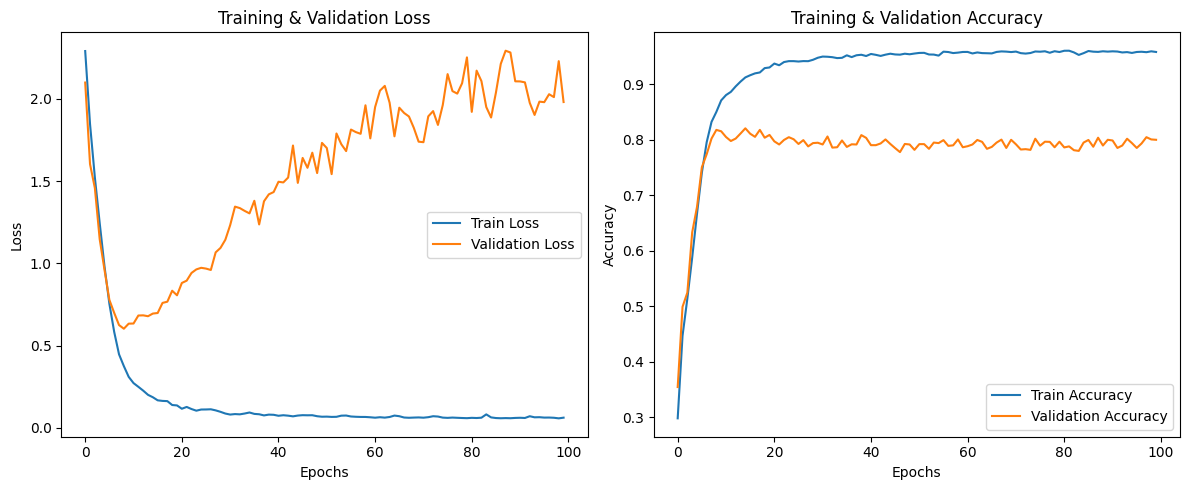

In [19]:
plt.figure(figsize=(12, 5))

# V·∫Ω ƒë·ªì th·ªã loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training & Validation Loss')
plt.legend()

# V·∫Ω ƒë·ªì th·ªã accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training & Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


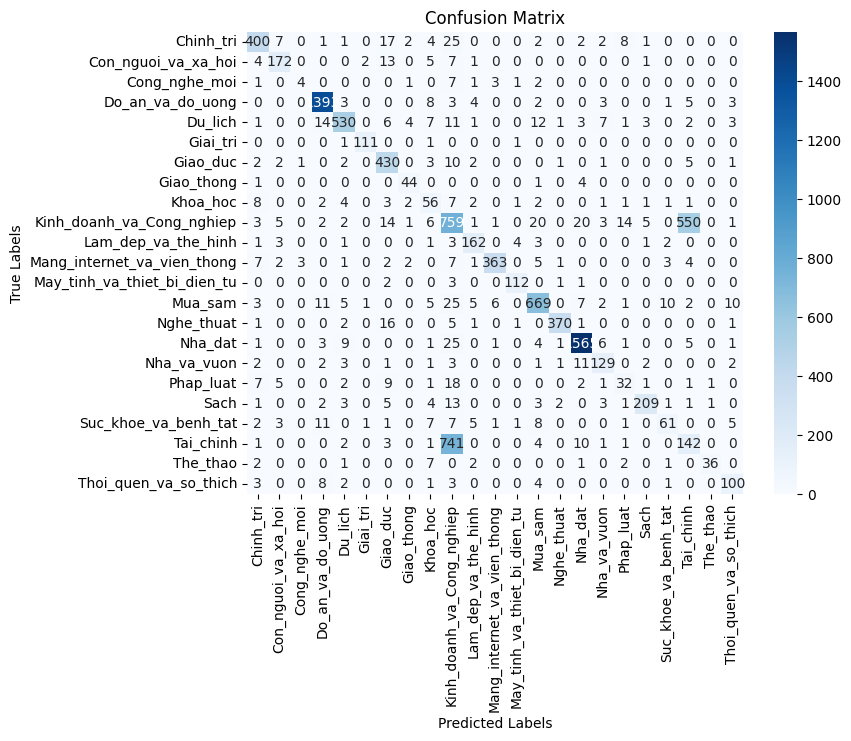

In [20]:
# T·∫°o ma tr·∫≠n nh·∫ßm l·∫´n
conf_matrix = confusion_matrix(test_labels_encoded, test_predicted_labels)

# V·∫Ω ma tr·∫≠n nh·∫ßm l·∫´n
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()